In [1]:
### Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
### Loading the data and selecting the target feature
# --- 1. Load data ---
gene_expression = pd.read_csv('top_variable_genes_tpm.csv', index_col=0)
sample_metadata_2 = pd.read_csv('sample_metadata_2.csv', index_col=0)

# --- 2. Preprocess gene expression ---
gene_expression = np.log2(gene_expression + 1)

# --- 3. Select and preprocess metadata features ---
# metadata_features = ['tumor_grade', 'vital_status', 'classification_of_tumor', 'primary_diagnosis', 'ajcc_pathologic_t']
metadata_features = sample_metadata_2.columns

In [3]:
### For target feature selection
# Get features with ≥3 unique classes but <10 (to avoid high-cardinality)
metadata_features_3_orMoreUnique = [
    col for col in metadata_features
    if 3 <= sample_metadata_2[col].nunique() < 10
]

print("Features with 3+ classes:", metadata_features_3_orMoreUnique)
print("\nClass distributions:")
for feature in metadata_features_3_orMoreUnique:
    counts = sample_metadata_2[feature].value_counts(dropna=False)
    print(f"\n--- {feature} ---\n{counts}")

Features with 3+ classes: ['morphology', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'classification_of_tumor', 'site_of_resection_or_biopsy', 'figo_stage', 'synchronous_malignancy', 'laterality', 'method_of_diagnosis', 'tumor_grade', 'residual_disease', 'race', 'ethnicity', 'days_to_collection', 'initial_weight']

Class distributions:

--- morphology ---
morphology
8441/3     408
Unknown     18
8460/3       3
Name: count, dtype: int64

--- tissue_or_organ_of_origin ---
tissue_or_organ_of_origin
Ovary                            277
Not Reported                     148
Specified parts of peritoneum      3
Uterus, NOS                        1
Name: count, dtype: int64

--- primary_diagnosis ---
primary_diagnosis
Serous cystadenocarcinoma, NOS         408
Unknown                                 18
Papillary serous cystadenocarcinoma      3
Name: count, dtype: int64

--- classification_of_tumor ---
classification_of_tumor
primary                279
recurrence              86
Unknown 

In [4]:
### Encoding and preprocessing the data 
# --- 4. Encode target feature ---
target_variable = 'classification_of_tumor'
y_raw = sample_metadata_2[target_variable].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("\nEncoded classes for target variable:")
for idx, class_name in enumerate(le.classes_):
    print(f"{idx}: {class_name}")

# --- 5. Prepare metadata features for modeling ---
features_for_model = [col for col in metadata_features if col != target_variable]
metadata_model = sample_metadata_2[features_for_model].copy()
# Encode all selected metadata features
for col in features_for_model:
    metadata_model[col] = LabelEncoder().fit_transform(metadata_model[col].astype(str))

# --- 6. Align and merge data ---
# Ensure indices match (samples as rows)
X = gene_expression.join(metadata_model, how='inner')
# Align y to X
y_aligned = pd.Series(y, index=sample_metadata_2.index).loc[X.index]


# --- 7. Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 8. Remove rare classes (with <2 samples) from target variable ---
from collections import Counter
class_counts = Counter(y_aligned)
rare_classes = [cls for cls, count in class_counts.items() if count < 2]
mask = ~y_aligned.isin(rare_classes)
X_filtered = X_scaled[mask]
y_filtered = y_aligned[mask]

print("\nFiltered class distribution in target variable:")
print(pd.Series(y_filtered).value_counts())


Encoded classes for target variable:
0: Progression
1: Synchronous primary
2: Unknown
3: metastasis
4: primary
5: recurrence

Filtered class distribution in target variable:
4    279
5     86
2     37
3     15
0     10
1      2
Name: count, dtype: int64


In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

# Scale features (crucial for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train SVM model
svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm.fit(X_train_scaled, y_train)


SVC(class_weight='balanced', random_state=42)

Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.57      0.50      0.53         8
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        56
           5       0.65      0.88      0.75        17

    accuracy                           0.87        86
   macro avg       0.44      0.48      0.46        86
weighted avg       0.83      0.87      0.85        86



c:\Users\khush\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\khush\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\khush\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


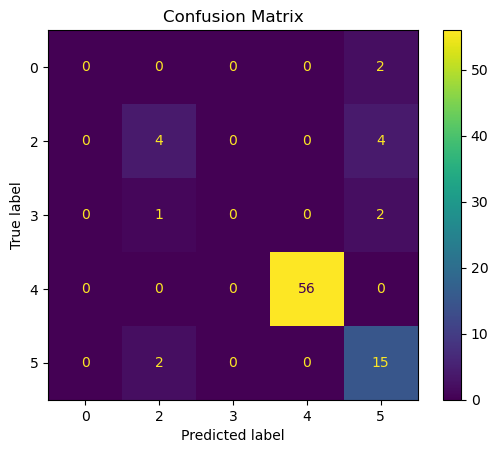

c:\Users\khush\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


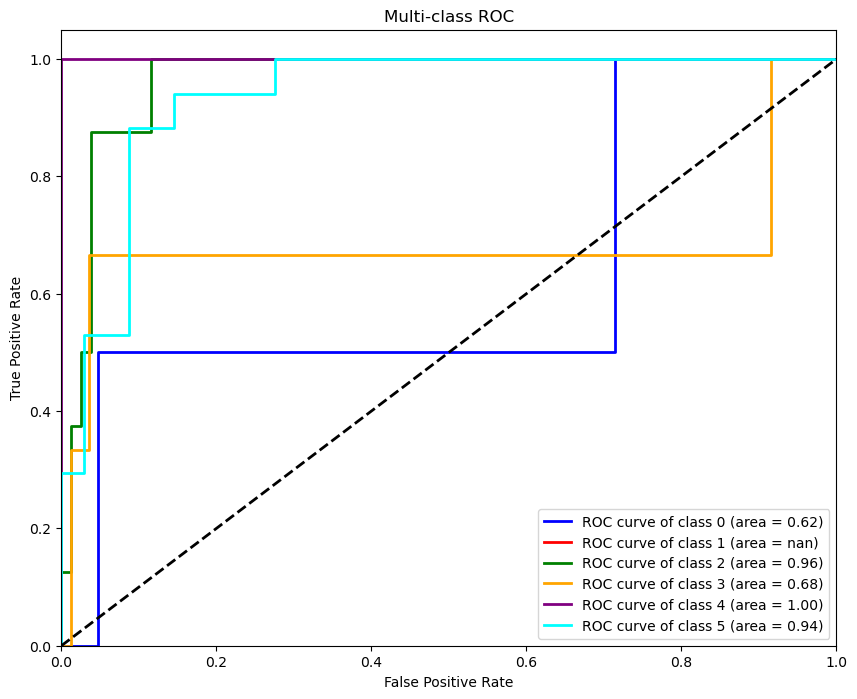

In [6]:
# Make predictions
y_pred = svm.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate detailed classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix')
plt.show()

# For multiclass problems, calculate ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Get unique classes
classes = np.unique(y_filtered)
n_classes = len(classes)

# Binarize the output for ROC calculation
y_test_bin = label_binarize(y_test, classes=classes)
y_score = svm.decision_function(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

if n_classes > 2:  # Multiclass case
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple','cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()